In [4]:
# EDA for the uploaded dataset: /mnt/data/btcusdt_5min_features.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import io, textwrap


# ---------- Load
path = Path("/teamspace/studios/this_studio/informer-validation/data/btcusdt_5min_features.csv")
df = pd.read_csv(path)

# Try to infer datetime column
dt_col_candidates = [c for c in df.columns if c.lower() in {"timestamp","time","date","datetime","dt"} or "time" in c.lower() or "date" in c.lower()]
dt_col = None
for c in dt_col_candidates:
    try:
        parsed = pd.to_datetime(df[c])
        df[c] = parsed
        dt_col = c
        break
    except Exception:
        continue

# If we found one, sort by time
if dt_col is not None:
    df = df.sort_values(dt_col).reset_index(drop=True)

# ---------- Basic info
head_buf = io.StringIO()
df.info(buf=head_buf)
basic_info = head_buf.getvalue()

summary = {
    "n_rows": len(df),
    "n_cols": df.shape[1],
    "datetime_column": dt_col,
    "columns": df.columns.tolist()[:50],
}

# Missing values
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean() * 100).sort_values(ascending=False)
na_table = pd.DataFrame({"missing_count": na_counts, "missing_pct": na_pct})

# Show a small sample to the user
print("Dataset preview (first 200 rows)") 
df.head(200)



Dataset preview (first 200 rows)


,close,high,low,open,volume,fng_value,vix_value,fed_funds_rate,datetime,group_id,...,ema_1d_to_close,vol_7d,sma_7d_to_close,macd,macd_signal,rsi,low_bband_to_close,up_bband_to_close,mid_bband_to_close,time_index
0,16543.67,16544.76,16538.45,16541.77,83.08143,26.0,21.67,4.33,2023-01-01 00:00:00,BTCUSDT,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,16536.70,16537.80,16533.94,16534.91,53.58957,26.0,21.67,4.33,2023-01-01 00:05:00,BTCUSDT,...,0.0,0.000421,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,16525.34,16530.87,16522.55,16526.67,96.60421,26.0,21.67,4.33,2023-01-01 00:10:00,BTCUSDT,...,0.0,0.000806,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,16521.00,16526.84,16519.40,16521.26,114.31289,26.0,21.67,4.33,2023-01-01 00:15:00,BTCUSDT,...,0.0,0.000848,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
4,16536.61,16537.82,16534.15,16534.94,37.63557,26.0,21.67,4.33,2023-01-01 00:20:00,BTCUSDT,...,0.0,0.001269,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,16567.04,16567.73,16562.45,16562.45,105.93480,26.0,21.67,4.33,2023-01-01 16:15:00,BTCUSDT,...,0.0,0.004236,0.0,2.984007,0.340140,67.335714,0.998021,0.999892,0.998956,195
196,16565.75,16572.72,16565.05,16572.72,111.37342,26.0,21.67,4.33,2023-01-01 16:20:00,BTCUSDT,...,0.0,0.004237,0.0,3.615848,0.995282,65.393015,0.998051,1.000102,0.999076,196
197,16571.16,16572.21,16568.64,16571.31,49.47764,26.0,21.67,4.33,2023-01-01 16:25:00,BTCUSDT,...,0.0,0.004249,0.0,4.501241,1.696473,69.382543,0.997669,0.999978,0.998823,197
198,16574.77,16581.29,16573.54,16578.16,116.06489,26.0,21.67,4.33,2023-01-01 16:30:00,BTCUSDT,...,0.0,0.004255,0.0,5.431606,2.443500,71.724917,0.997374,0.999981,0.998677,198


In [5]:

# ---------- Candidate targets
target_candidates = [c for c in df.columns if c.lower() in {"close","returns","ret","y","target","r"} or "return" in c.lower() or "close" in c.lower()]
target_candidates = list(dict.fromkeys(target_candidates))  # keep order & unique

# ---------- Basic stats for likely targets
stats_tables = {}
for col in target_candidates[:6]:
    if np.issubdtype(df[col].dtype, np.number):
        s = df[col].dropna()
        stats_tables[col] = pd.Series({
            "count": s.size,
            "mean": s.mean(),
            "std": s.std(ddof=0),
            "skew": s.skew(),
            "kurt": s.kurt(),
            "min": s.min(),
            "p01": s.quantile(0.01),
            "p05": s.quantile(0.05),
            "p25": s.quantile(0.25),
            "median": s.median(),
            "p75": s.quantile(0.75),
            "p95": s.quantile(0.95),
            "p99": s.quantile(0.99),
            "max": s.max(),
        })

stats_df = pd.DataFrame(stats_tables).T
stats_df.round(6)



,count,mean,std,skew,kurt,min,p01,p05,p25,median,p75,p95,p99,max
close,230688.0,51631.476891,24914.152056,0.544857,-0.839552,16508.480000,17124.435800,22812.265000,28130.467500,45643.595000,67155.947500,98157.500000,104629.719100,109194.170000
open_to_close,230688.0,1.000000,0.000738,0.420459,69.047791,0.971736,0.997998,0.998984,0.999711,1.000000,1.000289,1.001017,1.001971,1.030524
high_to_close,230688.0,1.000359,0.000569,6.759916,143.368645,1.000000,1.000000,1.000000,1.000000,1.000178,1.000487,1.001311,1.002444,1.031643
low_to_close,230688.0,0.999637,0.000575,-6.173485,108.850146,0.971736,0.997483,0.998674,0.999512,0.999820,1.000000,1.000000,1.000000,1.000000
returns,230688.0,0.000008,0.001514,-0.554373,60.869834,-0.068025,-0.004255,-0.002075,-0.000579,0.000000,0.000598,0.002110,0.004258,0.062160
returns_binary,230688.0,0.500069,0.500000,-0.000277,-2.000017,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


"\nBasic dataset info:\n- Rows: 230,688\n- Cols: 34\n- Datetime column: datetime\n- Candidate target columns (first 6): ['close', 'open_to_close', 'high_to_close', 'low_to_close', 'returns', 'returns_binary']\n\nMissing values (top 15):\n                missing_count  missing_pct\nclose                       0          0.0\nhigh                        0          0.0\nlow                         0          0.0\nopen                        0          0.0\nvolume                      0          0.0\nfng_value                   0          0.0\nvix_value                   0          0.0\nfed_funds_rate              0          0.0\ndatetime                    0          0.0\ngroup_id                    0          0.0\nhour                        0          0.0\nweekday                     0          0.0\nopen_to_close               0          0.0\nhigh_to_close               0          0.0\nlow_to_close                0          0.0\n\nEngineered columns added:\n- roll_vol_1d (rolling std ~1

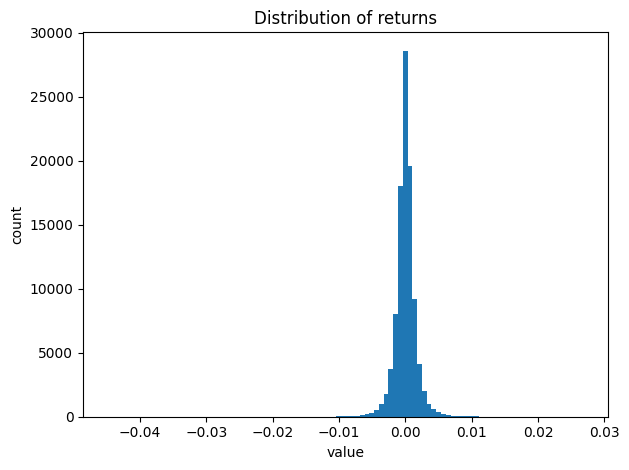

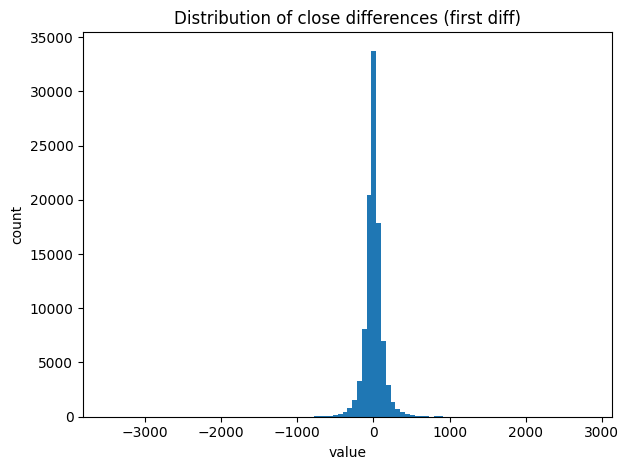

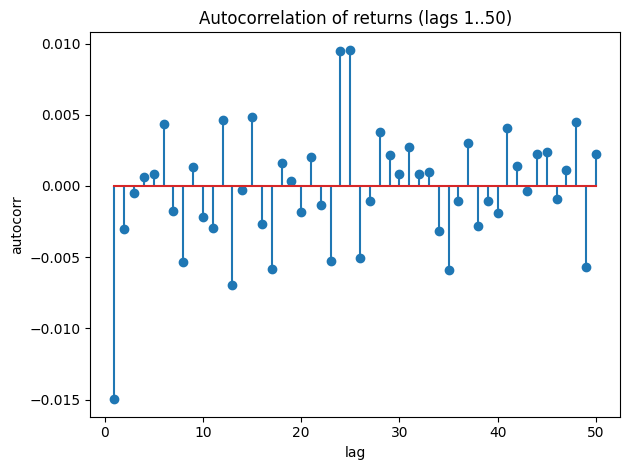

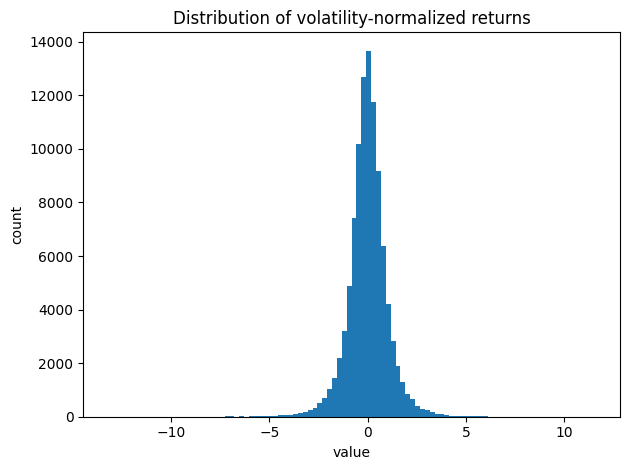

In [7]:
# ---------- Plots (matplotlib only)
# 1) Histograms for up to two targets: 'returns' and 'close' if present
def safe_hist(series, title):
    plt.figure()
    s = pd.Series(series).dropna().values
    if len(s) > 100000:
        s = s[-100000:]
    plt.hist(s, bins=100)
    plt.title(title)
    plt.xlabel("value")
    plt.ylabel("count")
    plt.tight_layout()

if "returns" in df.columns and np.issubdtype(df["returns"].dtype, np.number):
    safe_hist(df["returns"], "Distribution of returns")
if "close" in df.columns and np.issubdtype(df["close"].dtype, np.number):
    # plot simple differences for 'close' to see stationarity
    close_diff = pd.Series(df["close"]).diff()
    safe_hist(close_diff, "Distribution of close differences (first diff)")

# 2) Autocorrelation (simple lag-1..50) for returns if present
def simple_autocorr(x, max_lag=50):
    x = pd.Series(x).dropna().values
    x = x - x.mean()
    ac = []
    denom = (x**2).sum()
    for lag in range(1, max_lag+1):
        if lag >= len(x):
            ac.append(np.nan)
            continue
        ac_num = (x[:-lag] * x[lag:]).sum()
        ac.append(ac_num / denom if denom != 0 else np.nan)
    return np.array(ac)

if "returns" in df.columns and np.issubdtype(df["returns"].dtype, np.number):
    ac = simple_autocorr(df["returns"], max_lag=50)
    plt.figure()
    plt.stem(range(1, len(ac)+1), ac)
    plt.title("Autocorrelation of returns (lags 1..50)")
    plt.xlabel("lag")
    plt.ylabel("autocorr")
    plt.tight_layout()

# 3) Rolling volatility & volatility-normalized returns
engineered_cols_text = ""
if "returns" in df.columns and np.issubdtype(df["returns"].dtype, np.number):
    r = pd.Series(df["returns"]).astype(float)
    vol = r.rolling(288, min_periods=50).std()  # ~1 day for 5-min bars (288 per day)
    vnorm = r / (vol.replace(0, np.nan))
    df["roll_vol_1d"] = vol
    df["ret_volnorm"] = vnorm
    engineered_cols_text += "- roll_vol_1d (rolling std ~1 day)\n- ret_volnorm (returns / rolling std)\n"
    # Show histogram of vol-normalized returns
    safe_hist(df["ret_volnorm"], "Distribution of volatility-normalized returns")

# 4) Direction label, magnitude, clipped targets
if "returns" in df.columns and np.issubdtype(df["returns"].dtype, np.number):
    r = pd.Series(df["returns"]).astype(float)
    df["y_dir"] = np.sign(r).astype(int)  # -1,0,1
    df["y_mag"] = np.abs(r)
    # winsorize extreme tails at 0.5%/99.5% for stability
    lo, hi = r.quantile(0.005), r.quantile(0.995)
    df["ret_wins"] = r.clip(lo, hi)
    engineered_cols_text += "- y_dir (sign)\n- y_mag (abs magnitude)\n- ret_wins (winsorized returns)\n"

# Save engineered version for the user
out_path = Path("/teamspace/studios/this_studio/informer-validation/outputs/btcusdt_5min_features_engineered.csv")
df.to_csv(out_path, index=False)

# Prepare a short textual report
report = f"""
Basic dataset info:
- Rows: {summary['n_rows']:,}
- Cols: {summary['n_cols']}
- Datetime column: {summary['datetime_column']}
- Candidate target columns (first 6): {target_candidates[:6]}

Missing values (top 15):
{na_table.head(15).to_string()}

Engineered columns added:
{engineered_cols_text or "(none – 'returns' not found)"}

Saved engineered dataset to: {out_path}
"""

report